# CrimeCast: Forecasting Crime Categories

## Data Loading

In [642]:
import numpy as np; import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt; import seaborn as sns

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
X = train_df.copy()

## Exploratory Data Analysis

In [643]:
print(X.shape)
print("No of dupliates: ",X.duplicated().sum())
X.drop_duplicates(inplace=True)
X.reset_index(drop=True, inplace=True)
print(X.shape)

(20000, 22)
No of dupliates:  13
(19987, 22)


In [644]:
X.sample(6)

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
16171,WASHINGTON,MAGNOLIA,34.0400,-118.2864,01/13/2020 12:00:00 AM,01/12/2020 12:00:00 AM,10.0,20.0,Olympic,2099.0,1.0,0344 0358 1307 1609,31.0,M,B,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
14792,STRATHERN,LAUREL CANYON,34.2158,-118.3965,03/08/2020 12:00:00 AM,03/07/2020 12:00:00 AM,2200.0,16.0,Foothill,1684.0,1.0,NaN,0.0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
6365,7000 ALABAMA AV,NaN,34.1974,-118.5990,12/08/2020 12:00:00 AM,12/08/2020 12:00:00 AM,820.0,21.0,Topanga,2146.0,2.0,2000 0416,19.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,Violent Crimes
15898,4300 W 3RD ST,NaN,34.0690,-118.3135,04/14/2020 12:00:00 AM,04/13/2020 12:00:00 AM,1800.0,20.0,Olympic,2022.0,1.0,0344 0386,43.0,M,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,Property Crimes
477,1500 E 21ST ST,NaN,34.0197,-118.2474,05/23/2020 12:00:00 AM,05/21/2020 12:00:00 AM,2330.0,13.0,Newton,1327.0,2.0,0329,43.0,F,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,Property Crimes
11322,800 W 126TH ST,NaN,33.9178,-118.2909,11/19/2020 12:00:00 AM,11/19/2020 12:00:00 AM,2140.0,18.0,Southeast,1831.0,2.0,0913 0416 2021 0603 1810,21.0,F,B,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes


Extracting Location column information

In [645]:
def extract_location_data(s):
    street_number = direction = street_name = street_type = None
    try: # steet number
        nt = s.split(' ')[0]
        street_number = nt if int(nt.isdigit()) else None
    except: pass
    try: # direction
        nt = [x.strip() for x in s.split(' ') if x.strip()]
        for x in nt:
            if x.isdigit(): continue
            elif len(x)>1: break
            if x in ['N', 'S', 'E', 'W']:
                direction = x; break
    except: pass
    try: # street type
        nt = s.split('   ')[-1].strip()
        street_type = nt if len(nt)==2 and not(nt.isdigit()) else None
    except: pass
    street_name = None # street name
    nt = [x.strip() for x in s.split('  ') if x.strip()]
    for x in nt:
        test_x = [x.strip() for x in x.split(' ') if x.strip()]
        if len(test_x)==1 and not(street_number and street_number == test_x[0]) and not(street_type and street_type == test_x[0]):
            street_name = x; break
        elif not(street_number and street_number in test_x):
            street_name = x; break
    return street_number, direction, street_name, street_type

def split_location_column(df):
    parsed_data = []
    for idx, row in df.iterrows():
        string = row['Location']
        street_number, direction, street_name, street_type = extract_location_data(string)
        parsed_data.append({
            'Location': string,
            'Street_Number': street_number,
            'Direction': direction,
            'Street_Name': street_name,
            'Street_Type': street_type
        })
    location_df = pd.DataFrame(parsed_data, index=df.index)
    df = df.drop(columns=['Location'])
    df = pd.concat([location_df,df], axis=1)
    return df

In [646]:
X = split_location_column(X)
X.sample(6)

,Location,Street_Number,Direction,Street_Name,Street_Type,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
13393,8400 AMIGO AV,8400,None,AMIGO,AV,NaN,34.2230,-118.5378,04/07/2020 12:00:00 AM,04/07/2020 12:00:00 AM,2050.0,17.0,Devonshire,1794.0,2.0,2038,37.0,F,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,Crimes against Public Order
1589,700 W 7TH ST,700,W,7TH,ST,NaN,34.0491,-118.2558,11/05/2020 12:00:00 AM,11/05/2020 12:00:00 AM,1900.0,1.0,Central,152.0,2.0,2000 0913 1814 0416,24.0,F,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes
4556,9700 ETON AV,9700,None,ETON,AV,NaN,34.2464,-118.5944,08/14/2020 12:00:00 AM,08/14/2020 12:00:00 AM,1035.0,17.0,Devonshire,1762.0,1.0,1501,0.0,M,X,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,Property Crimes
11264,1300 W SUNSET BL,1300,W,SUNSET,BL,NaN,34.0685,-118.2460,07/10/2020 12:00:00 AM,07/10/2020 12:00:00 AM,845.0,1.0,Central,101.0,1.0,1309 1822 0430 1100,31.0,F,B,102.0,SIDEWALK,102.0,HAND GUN,AA,Adult Arrest,Violent Crimes
9190,1900 LANDA ST,1900,None,LANDA,ST,NaN,34.0948,-118.2504,08/10/2020 12:00:00 AM,08/09/2020 12:00:00 AM,2300.0,11.0,Northeast,1173.0,1.0,NaN,0.0,NaN,NaN,104.0,DRIVEWAY,NaN,NaN,IC,Invest Cont,Property Crimes
7407,9800 NATIONAL BL,9800,None,NATIONAL,BL,NaN,34.0314,-118.3998,02/02/2020 12:00:00 AM,02/02/2020 12:00:00 AM,1145.0,8.0,West LA,896.0,2.0,0400 0408 0446 0429 2035 0417 0381 0342,54.0,M,B,402.0,MARKET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Violent Crimes


In [647]:
X.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,19987.000000,7330.000000
mean,33.940599,-117.892777,1352.428779,10.834442,1129.623005,1.418222,30.149497,297.179767,366.341201
std,2.127496,7.380116,645.997471,6.032913,603.310792,0.493279,21.861242,211.996875,120.495174
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.322900,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165050,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [648]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19987 entries, 0 to 19986
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               19987 non-null  object 
 1   Street_Number          16540 non-null  object 
 2   Direction              7043 non-null   object 
 3   Street_Name            19987 non-null  object 
 4   Street_Type            18180 non-null  object 
 5   Cross_Street           3447 non-null   object 
 6   Latitude               19987 non-null  float64
 7   Longitude              19987 non-null  float64
 8   Date_Reported          19987 non-null  object 
 9   Date_Occurred          19987 non-null  object 
 10  Time_Occurred          19987 non-null  float64
 11  Area_ID                19987 non-null  float64
 12  Area_Name              19987 non-null  object 
 13  Reporting_District_no  19987 non-null  float64
 14  Part 1-2               19987 non-null  float64
 15  Mo

In [649]:
X.isnull().mean() * 100

Location                  0.000000
Street_Number            17.246210
Direction                64.762095
Street_Name               0.000000
Street_Type               9.040877
Cross_Street             82.753790
Latitude                  0.000000
Longitude                 0.000000
Date_Reported             0.000000
Date_Occurred             0.000000
Time_Occurred             0.000000
Area_ID                   0.000000
Area_Name                 0.000000
Reporting_District_no     0.000000
Part 1-2                  0.000000
Modus_Operandi           13.698904
Victim_Age                0.000000
Victim_Sex               13.118527
Victim_Descent           13.118527
Premise_Code              0.000000
Premise_Description       0.025016
Weapon_Used_Code         63.326162
Weapon_Description       63.326162
Status                    0.000000
Status_Description        0.000000
Crime_Category            0.000000
dtype: float64

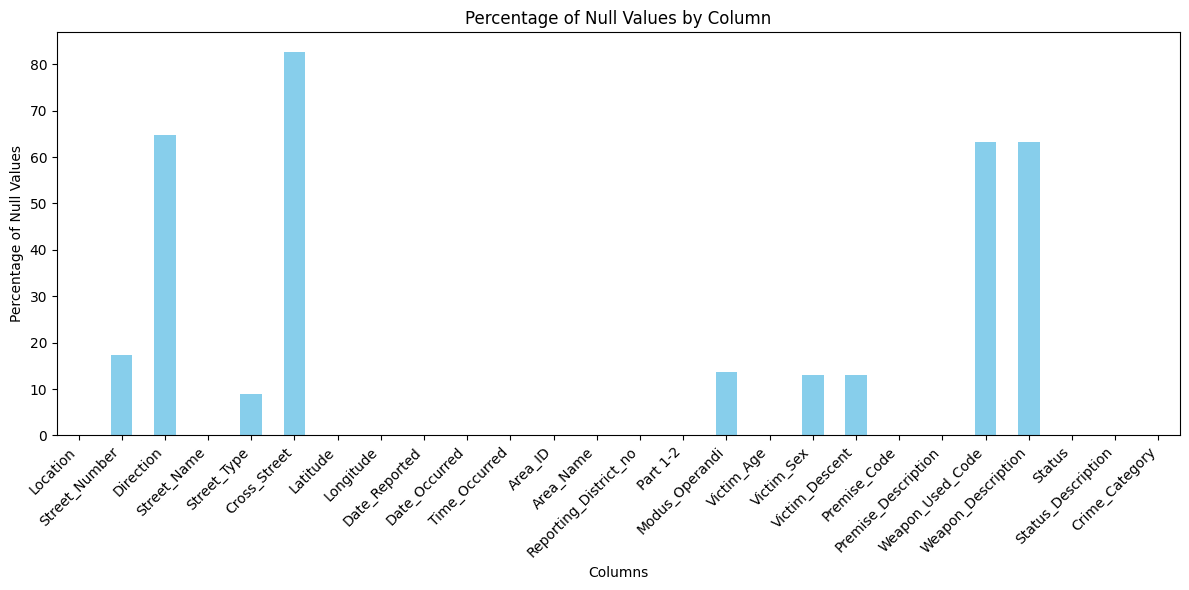

In [650]:
null_percentage = X.isnull().mean() * 100
plt.figure(figsize=(12, 6))
null_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Direction, Cross_Street, Weapon_Used_Code, and Weapon_Description have high percentages of missing values in your dataset. This suggests potential issues with the reliability and completeness of these features. However, from the perspective of domain knowledge in crime reporting, Weapon_Used_Code can still provide valuable insights.

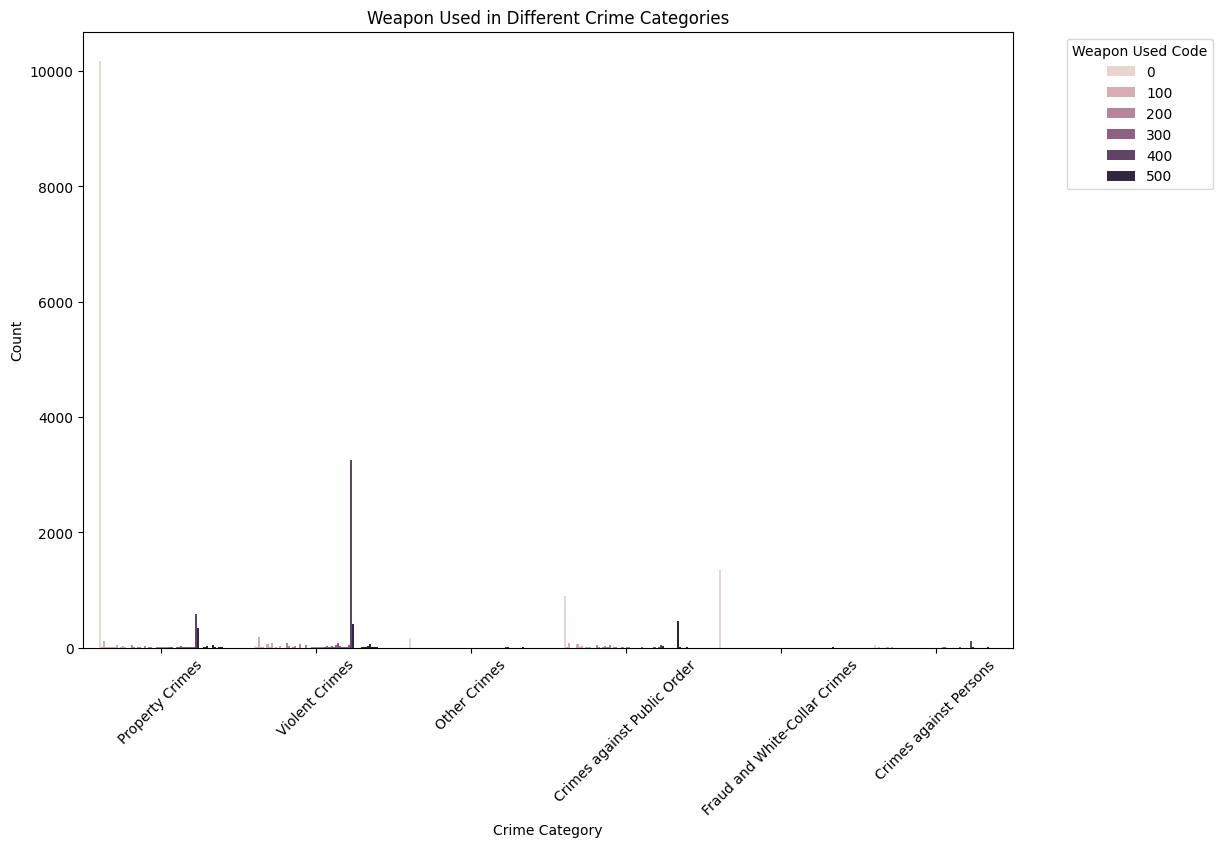

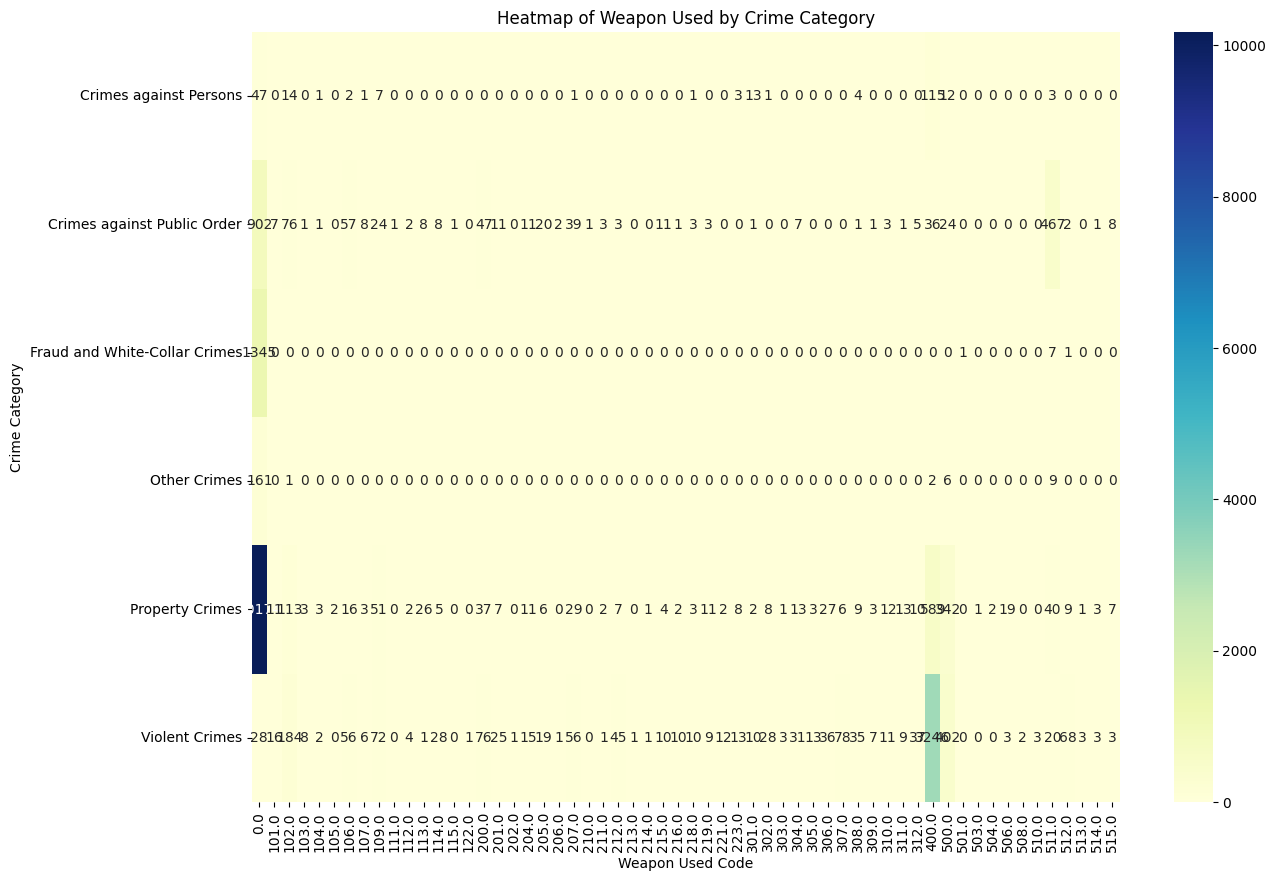

In [651]:
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # considering 0 as no weapon used

plt.figure(figsize=(12, 8))
sns.countplot(data=X, x='Crime_Category', hue='Weapon_Used_Code')
plt.title('Weapon Used in Different Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.legend(title='Weapon Used Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

pivot_table = pd.crosstab(X['Crime_Category'], X['Weapon_Used_Code'])
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Weapon Used by Crime Category')
plt.xlabel('Weapon Used Code')
plt.ylabel('Crime Category')
plt.show()

In [652]:
X.drop(columns=['Direction','Cross_Street','Weapon_Description'], inplace=True)
# dropping columns with high missing values other than weapon code as we can assume that those crime categories don't require weapon in genunie

In [653]:
unique_combinations = X.drop_duplicates(subset=['Street_Number', 'Street_Name'])
consistent = unique_combinations.shape[0] == X['Street_Number'].nunique()
print(f"Each Street_Number corresponds to a single Street_Name: {consistent}")

unique_combinations = X.drop_duplicates(subset=['Area_ID', 'Area_Name'])
consistent = unique_combinations.shape[0] == X['Area_ID'].nunique()
print(f"Each Area_ID corresponds to a single Area_Name: {consistent}")

unique_combinations = X.drop_duplicates(subset=['Premise_Code', 'Premise_Description'])
consistent = unique_combinations.shape[0] == X['Premise_Code'].nunique()
print(f"Each Premise_Code corresponds to a single Premise_Description: {consistent}")

unique_combinations = X.drop_duplicates(subset=['Status', 'Status_Description'])
consistent = unique_combinations.shape[0] == X['Status'].nunique()
print(f"Each Status corresponds to a single Status_Description: {consistent}")

Each Street_Number corresponds to a single Street_Name: False
Each Area_ID corresponds to a single Area_Name: True
Each Premise_Code corresponds to a single Premise_Description: True
Each Status corresponds to a single Status_Description: True


In [654]:
X.drop(columns=['Area_Name','Premise_Description','Status_Description'], inplace=True) # dropping same valued columns

In [655]:
street_groups = X.groupby('Street_Number')['Street_Name'].unique()
street_groups

Street_Number
00       [GATEWAY PLZ, 18TH, TOLUCA ESTATES, BROOKS, GA...
00000                                         [CLUB HOUSE]
00100                                          [NORMANDIE]
01200                                           [WILSHIRE]
01500                                               [92ND]
                               ...                        
9500     [NATIONAL, ZELZAH, WALL, RESEDA, MAIE, SYLMAR,...
9600     [ARLETA, LAWLEN, FIGUEROA, AIRPORT, SEPULVEDA,...
9700     [WENDOVER, SEPULVEDA, HADDON, AIRPORT, LAUREL ...
9800     [AIRPORT, BANDERA, VIDOR, LAUREL CANYON, VESPE...
9900     [SAN PEDRO, SEPULVEDA, ARLETA, JORDAN, TAMPA, ...
Name: Street_Name, Length: 267, dtype: object

Street_Number and Street_Name are not identical

<br>

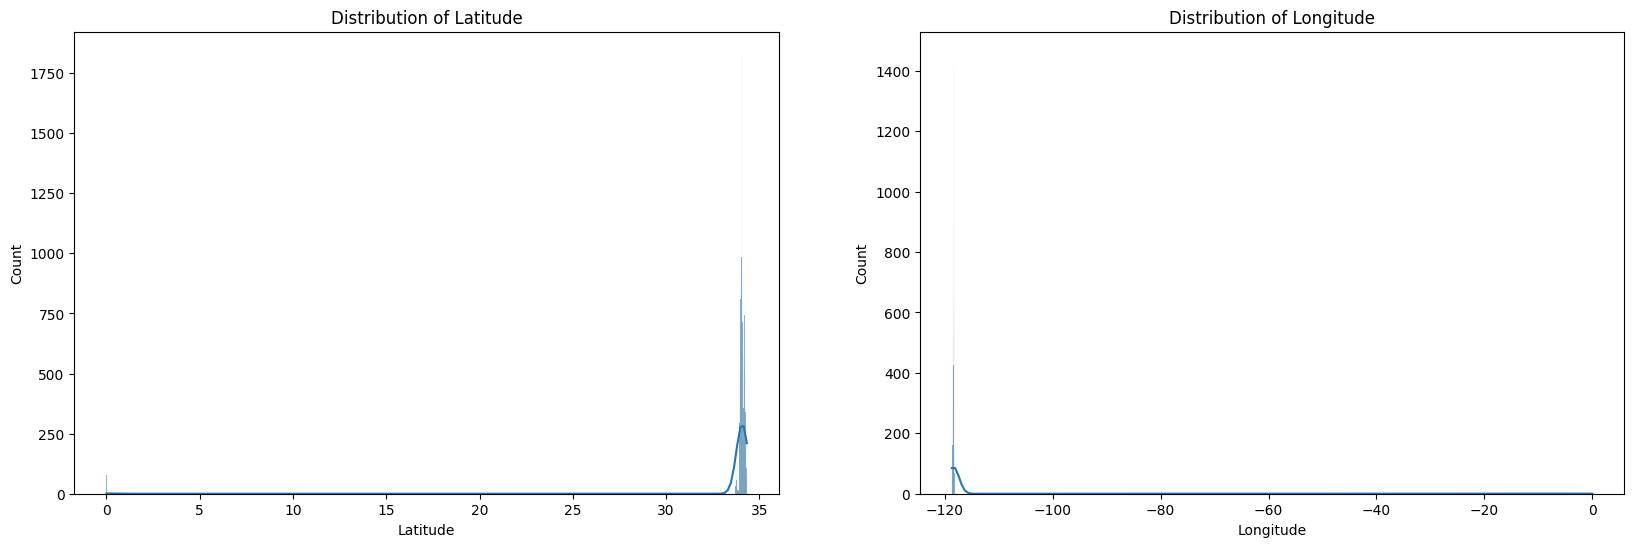

In [656]:
plt.figure(figsize=(20, 6))

# First subplot for Latitude
plt.subplot(1, 2, 1)
sns.histplot(X['Latitude'], kde=True)
plt.title('Distribution of Latitude')

# Second subplot for Longitude
plt.subplot(1, 2, 2)
sns.histplot(X['Longitude'], kde=True)
plt.title('Distribution of Longitude')

plt.show()

Text(0.5, 1.0, 'Distribution of Victim_Age')

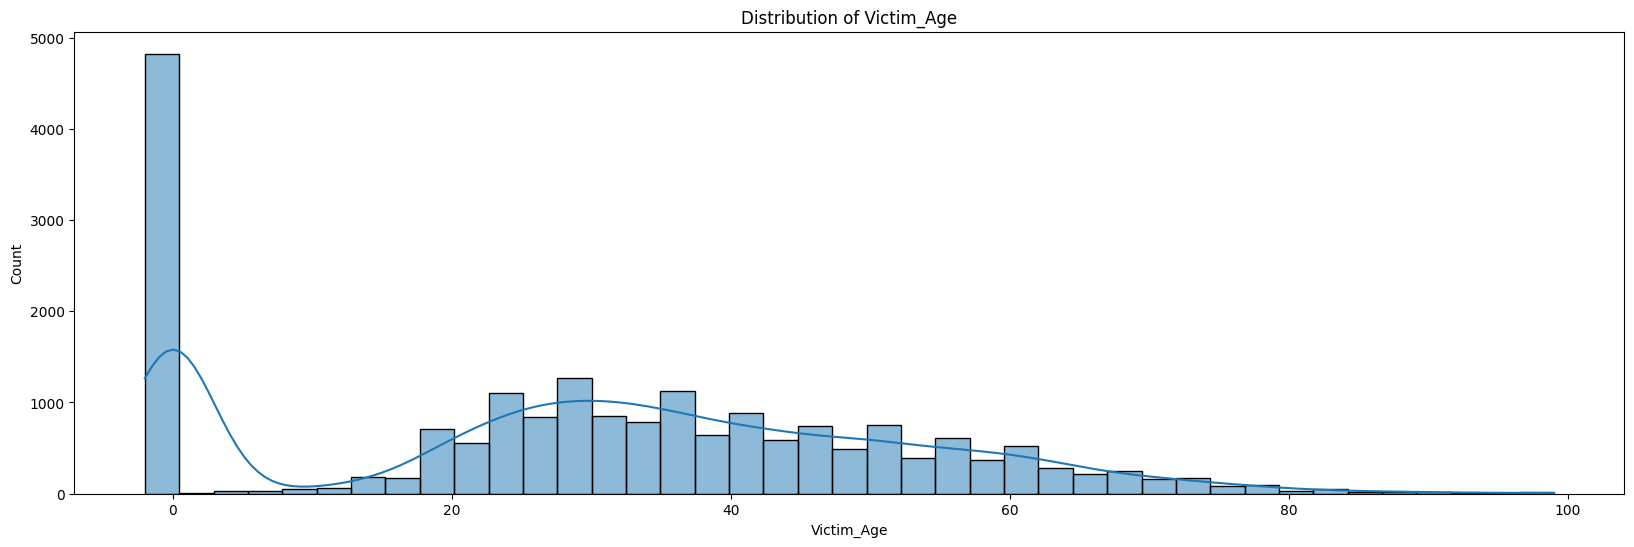

In [657]:
plt.figure(figsize=(20, 6))
sns.histplot(X['Victim_Age'], kde=True)
plt.title('Distribution of Victim_Age')

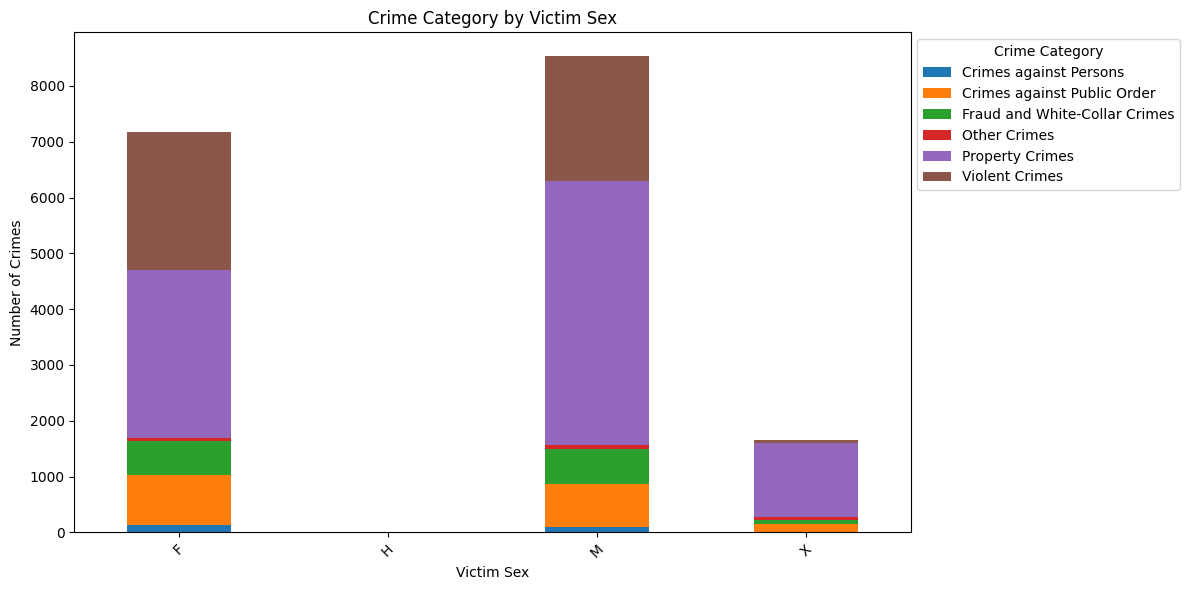

In [658]:
crime_counts = X.groupby(['Victim_Sex', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Victim Sex')
ax.set_xlabel('Victim Sex')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most crimes involve victims identified as either female (`F`) or male (`M`), with these two categories showing the highest numbers. Both Property Crimes and Violent Crimes are the most common types of offenses against these victims. The `X` category, though less frequent, follows a similar pattern in crime distribution, while the `H` category, has very few recorded cases. This distribution indicates that gender is a significant factor in the types of crimes committed, with serious offenses like violent and property crimes affecting both males and females.

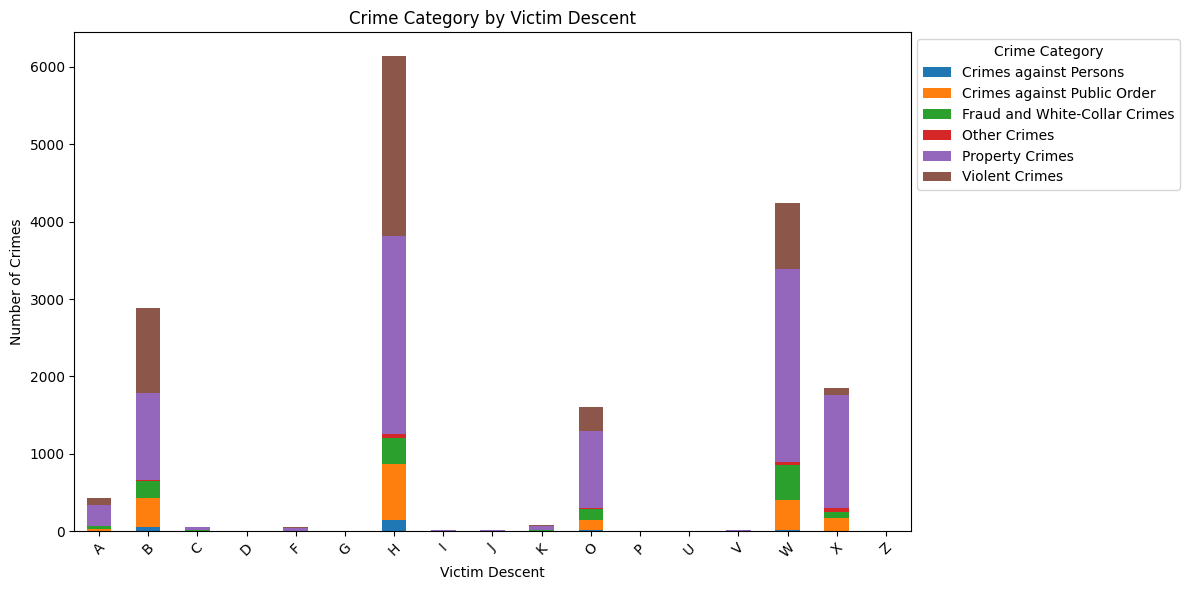

In [659]:
crime_counts = X.groupby(['Victim_Descent', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Victim Descent')
ax.set_xlabel('Victim Descent')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most crimes involve victims from specific descent groups, with the highest numbers observed in categories `H`, `W`, and `B`. Violent Crimes and Property Crimes are the most common types of offenses across these groups. In particular, victims of descent `H` (likely Hispanic) and `W` (likely White) are more frequently involved in serious crimes. Some descent groups, such as `C`, `F`, `I`, `J`, and `K`, have very few recorded cases, indicating that these categories are less represented or involve fewer crimes. The `+` category, possibly representing unknown or unspecified descent, also shows a moderate number of cases, mostly involving Property Crimes and Violent Crimes. This distribution suggests that certain descent groups are more frequently targeted in specific types of crimes, with serious offenses being particularly prevalent among `H`, `W`, and `B` descent groups.

Text(0.5, 1.0, 'Distribution of Time_Occurred')

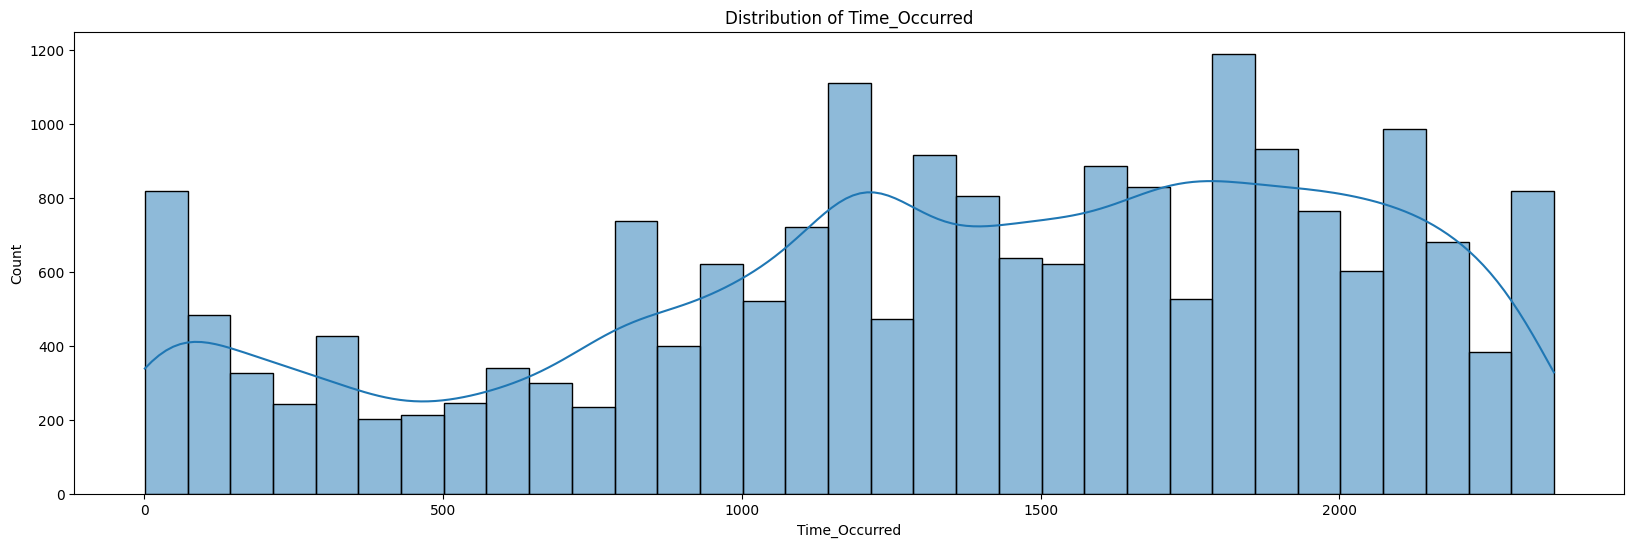

In [660]:
plt.figure(figsize=(20, 6))
sns.histplot(X['Time_Occurred'], kde=True)
plt.title('Distribution of Time_Occurred')

The histogram of the "Time Occurred" variable reveals distinct peaks at 0, 1250, and 2000, indicating higher frequencies of crimes occurred at these times. The peaks suggest periods of heightened activity, such as mid night, after noon, and evening.

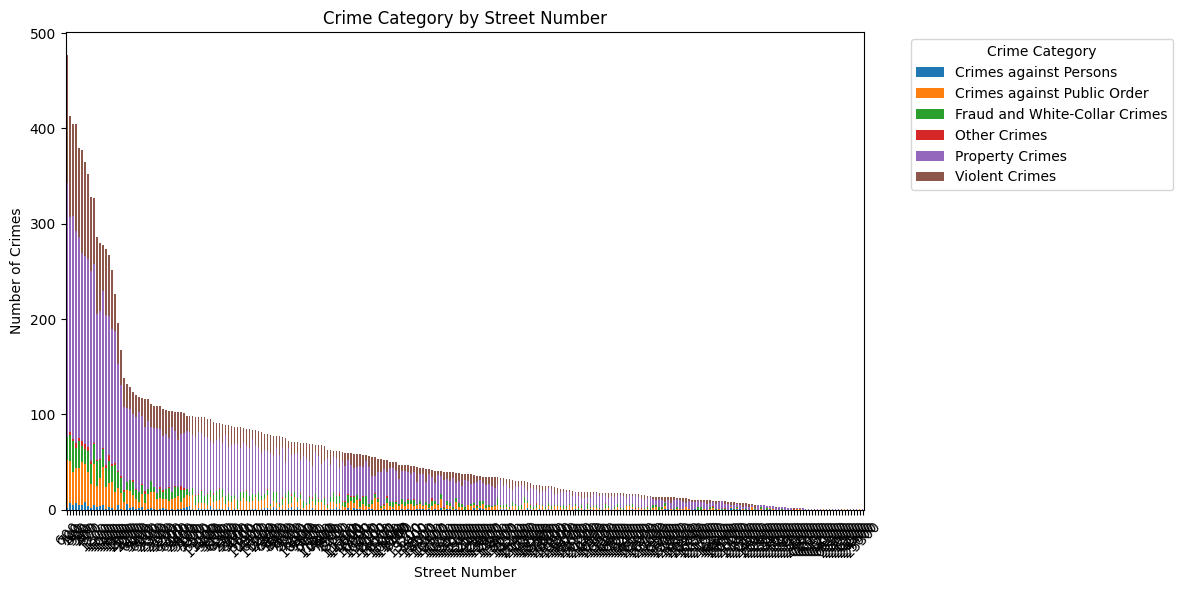

In [661]:
crime_counts = X.groupby(['Street_Number', 'Crime_Category']).size().unstack().fillna(0)
crime_counts['Total'] = crime_counts.sum(axis=1)
crime_counts = crime_counts.sort_values(by='Total', ascending=False)
crime_counts = crime_counts.drop(columns=['Total'])
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Street Number')
ax.set_xlabel('Street Number')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph reveals significant variability in crime data, with certain street numbers exhibiting much higher crime rates than others. This variability is also seen within different crime categories, where some crimes are more concentrated in specific areas.

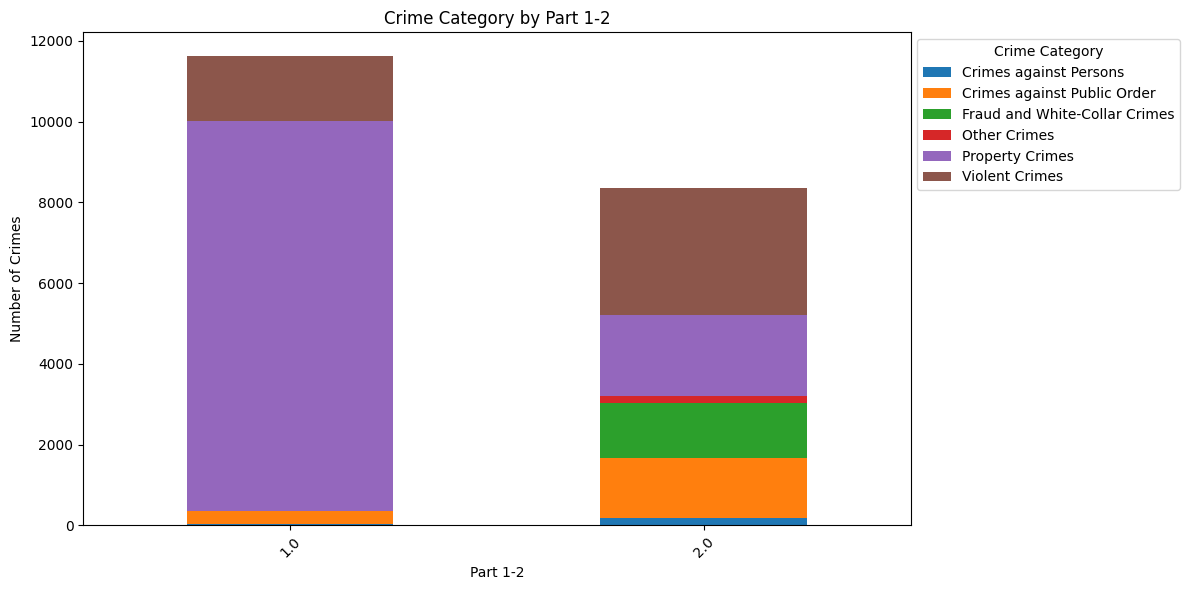

In [662]:
crime_counts = X.groupby(['Part 1-2', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Part 1-2')
ax.set_xlabel('Part 1-2')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on domain knowledge and common crime classification practices, it's actually more likely that `Part 1` crimes are considered more serious, while `Part 2` crimes are generally less serious. This understanding aligns with the patterns observed in the graph, where `Part 1` shows a higher concentration of more severe crime categories like **Property Crimes** and **Violent Crimes**, while `Part 2` includes a broader range of less severe offenses. Given this distinction, it would be appropriate to use ordinal encoding for the `Part 1-2` variable in a machine learning model. Ordinal encoding would allow the model to recognize and utilize the inherent order in crime severity, treating `Part 1` as more severe (e.g., encoding it with a higher value) and `Part 2` as less severe, which can improve the model's ability to predict outcomes related to crime severity.

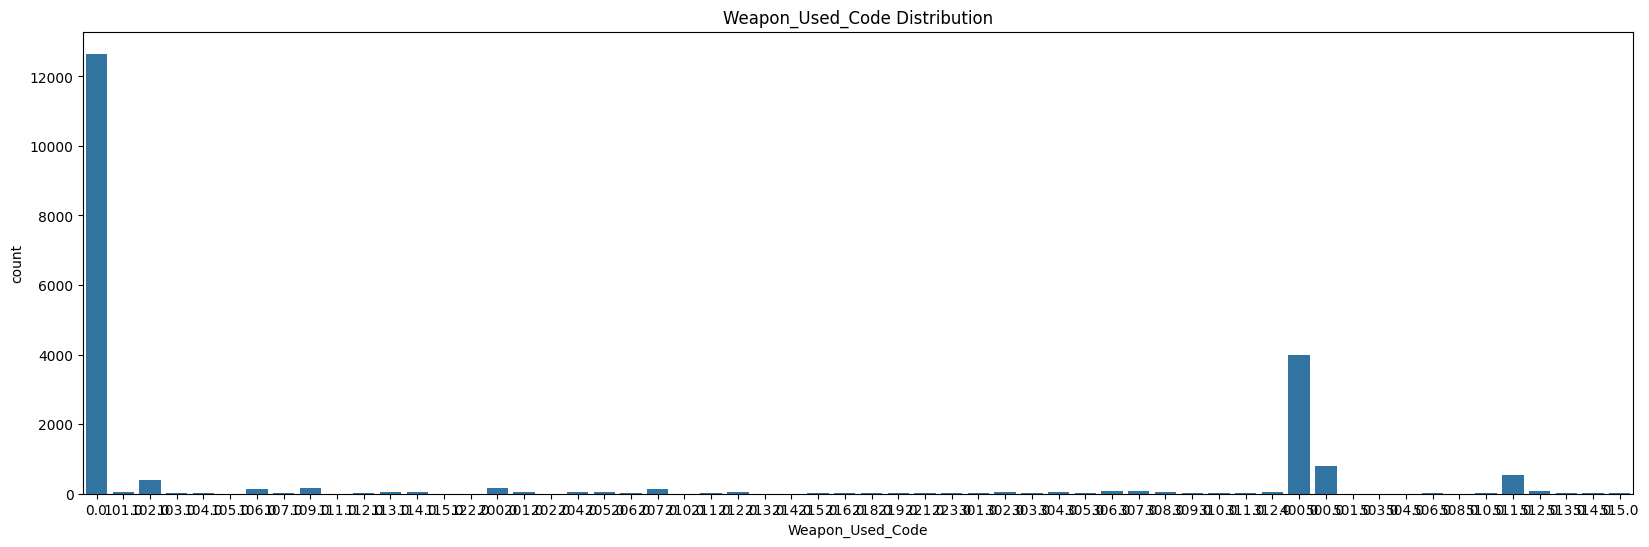

In [663]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Weapon_Used_Code', data=X)
plt.title('Weapon_Used_Code Distribution')
plt.show()

In [664]:
X['Weapon_Used_Code'].value_counts().head(6)

Weapon_Used_Code
0.0      12657
400.0     3988
500.0      786
511.0      546
102.0      388
200.0      160
Name: count, dtype: int64

In [665]:
top_6_weapon_codes = train_df['Weapon_Used_Code'].value_counts().head(6).index.tolist()
filtered_df = train_df[train_df['Weapon_Used_Code'].isin([400.0, 500.0, 511.0, 102.0, 200.0])][['Weapon_Used_Code', 'Weapon_Description']].drop_duplicates()
sorted_df = filtered_df.assign(
    Weapon_Used_Code=pd.Categorical(
        filtered_df['Weapon_Used_Code'],
        categories=top_6_weapon_codes,
        ordered=True
    )
).sort_values('Weapon_Used_Code')
sorted_df

,Weapon_Used_Code,Weapon_Description
1,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
17,500.0,UNKNOWN WEAPON/OTHER WEAPON
11,511.0,VERBAL THREAT
14,102.0,HAND GUN
98,200.0,KNIFE WITH BLADE 6INCHES OR LESS


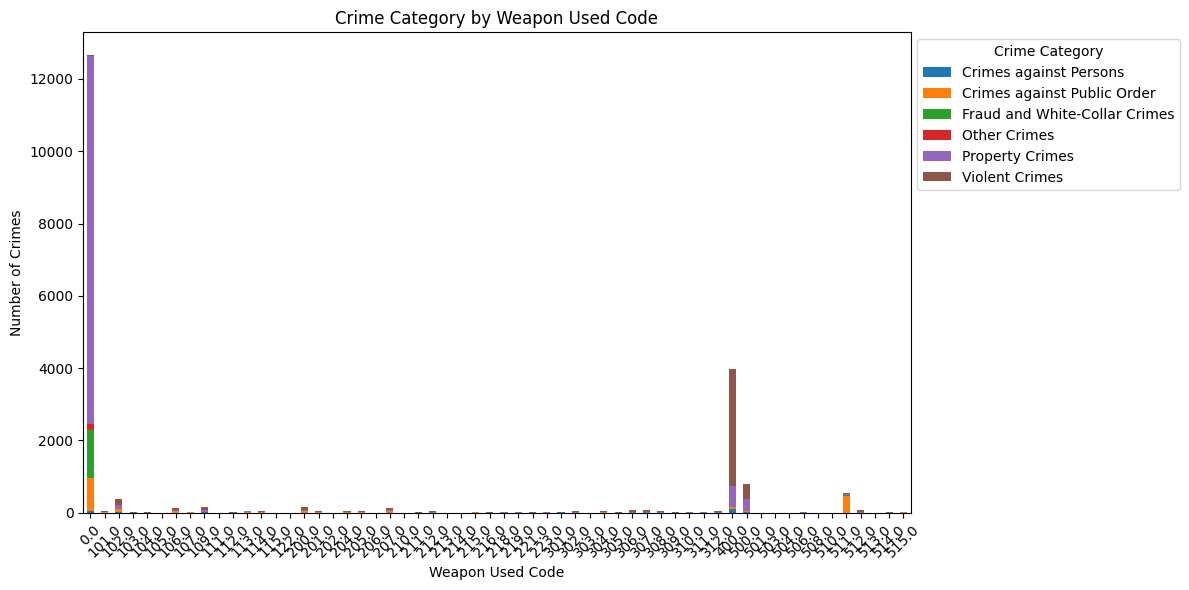

In [666]:
crime_counts = X.groupby(['Weapon_Used_Code', 'Crime_Category']).size().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(12, 6))
crime_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Crime Category by Weapon Used Code')
ax.set_xlabel('Weapon Used Code')
ax.set_ylabel('Number of Crimes')
ax.legend(title='Crime Category', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| Weapon_Used_Code | Weapon_Description                              |
|------------------|-------------------------------------------------|
| 400.0            | STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)  |
| 500.0            | UNKNOWN WEAPON/OTHER WEAPON                     |
| 511.0            | VERBAL THREAT                                   |
| 102.0            | HAND GUN                                        |
| 200.0            | KNIFE WITH BLADE 6 INCHES OR LESS               |
----------------------------------------------------------------------
The data reveals that the `400` Weapon Code, representing **STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)**, and the `500` Weapon Code, indicating **UNKNOWN WEAPON/OTHER WEAPON**, are predominantly associated with Violent Crimes. Additionally, in the context of Crimes against Public Order, the `511` Weapon Code, corresponding to **VERBAL THREAT**, is used more frequently. This pattern highlights the prevalence of physical force and unidentified weapons in violent offenses, while verbal threats are more commonly linked to public order crimes.

In [667]:
# heat map to show relation between modus_operandi and crime_category
X['Modus_Operandi']

0                                           0385
1        0906 0352 0371 0446 1822 0344 0416 0417
2                                      0329 1202
3                                      0329 1300
4                  0416 0945 1822 0400 0417 0344
                          ...                   
19982                        0416 0446 2004 0913
19983                   1822 0209 0344 1414 1420
19984                             0344 1822 1420
19985              1202 2038 0913 0602 1242 0553
19986                                        NaN
Name: Modus_Operandi, Length: 19987, dtype: object

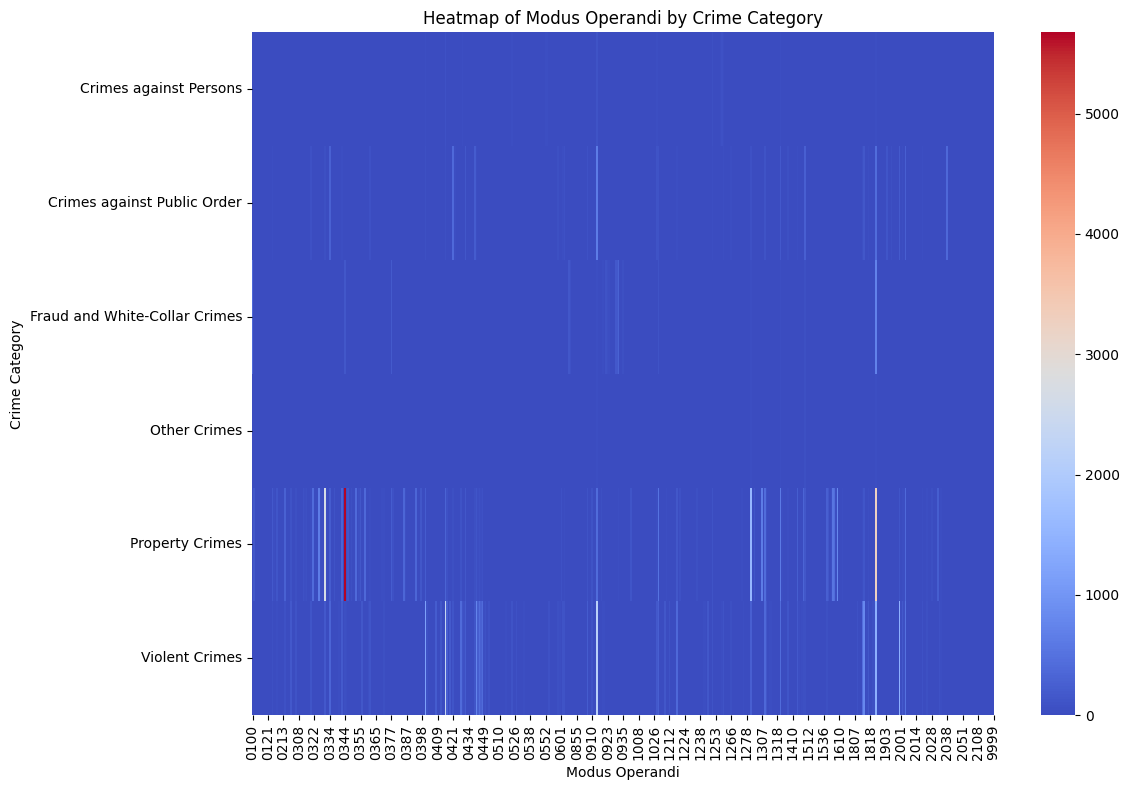

In [668]:
X['Modus_Operandi_List'] = X['Modus_Operandi'].fillna('').apply(lambda x: x.split())
modus_operandi_df = X.explode('Modus_Operandi_List')
modus_operandi_df['count'] = 1
heatmap_data = modus_operandi_df.pivot_table(
    index='Crime_Category',
    columns='Modus_Operandi_List',
    values='count',
    aggfunc='sum',
    fill_value=0
)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, fmt="d")
plt.title('Heatmap of Modus Operandi by Crime Category')
plt.xlabel('Modus Operandi')
plt.ylabel('Crime Category')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## PreProcessing

In [669]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

class LocationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, location_col='Location'):
        self.location_col = location_col
    def extract_location_data(self, s):
        street_number = direction = street_name = street_type = None
        try:  # street number
            nt = s.split(' ')[0]
            street_number = nt if int(nt.isdigit()) else None
        except: pass
        try:  # direction
            nt = [x.strip() for x in s.split(' ') if x.strip()]
            for x in nt:
                if x.isdigit(): continue
                elif len(x) > 1: break
                if x in ['N', 'S', 'E', 'W']:
                    direction = x
                    break
        except: pass
        try:  # street type
            nt = s.split('   ')[-1].strip()
            street_type = nt if len(nt) == 2 and not(nt.isdigit()) else None
        except: pass
        street_name = None  # street name
        nt = [x.strip() for x in s.split('  ') if x.strip()]
        for x in nt:
            test_x = [x.strip() for x in x.split(' ') if x.strip()]
            if len(test_x) == 1 and not(street_number and street_number == test_x[0]) and not(street_type and street_type == test_x[0]):
                street_name = x
                break
            elif not(street_number and street_number in test_x):
                street_name = x
                break
        return street_number, direction, street_name, street_type
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        parsed_data = []
        for idx, row in X.iterrows():
            string = row[self.location_col]
            street_number, direction, street_name, street_type = self.extract_location_data(string)
            parsed_data.append({
                'Street_Number': street_number,
                'Direction': direction,
                'Street_Name': street_name,
                'Street_Type': street_type
            })
        location_df = pd.DataFrame(parsed_data, index=X.index)
        return pd.concat([location_df, X.drop('Location',axis=1)], axis=1)
    
class ExtractDateTimeInfo(BaseEstimator, TransformerMixin):
    def __init__(self, date_reported_col='Date_Reported', date_occurred_col='Date_Occurred', time_occurred_col='Time_Occurred'):
        self.date_reported_col = date_reported_col
        self.date_occurred_col = date_occurred_col
        self.time_occurred_col = time_occurred_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X[self.date_reported_col] = pd.to_datetime(X[self.date_reported_col], format='%m/%d/%Y %I:%M:%S %p')
        X[self.date_occurred_col] = pd.to_datetime(X[self.date_occurred_col], format='%m/%d/%Y %I:%M:%S %p')
        def convert_time_occurred(time):
            time_str = f"{int(time):04d}"
            return f"{time_str[:2]}:{time_str[2:]}:00"
        X["Occurred_Time"] = X[self.time_occurred_col].apply(convert_time_occurred)
        X['Days_After_Reported'] = (X[self.date_reported_col] - X[self.date_occurred_col]).dt.days
        X['Reported_Day'] = X[self.date_reported_col].dt.day
        X['Reported_Month'] = X[self.date_reported_col].dt.month
        X['Reported_Weekday'] = X[self.date_reported_col].dt.weekday
        X['Occurred_Day'] = X[self.date_occurred_col].dt.day
        X['Occurred_Month'] = X[self.date_occurred_col].dt.month
        X['Occurred_Weekday'] = X[self.date_occurred_col].dt.weekday
        X['Occurred_Weekmonth'] = X[self.date_occurred_col].apply(lambda d: (d.day - 1) // 7 + 1)
        X['Occurred_Weekend?'] = np.where(X['Occurred_Weekday'].isin([5, 6]), 1, 0)
        X['Occurred_Hour'] = pd.to_datetime(X["Occurred_Time"], format='%H:%M:%S').dt.hour
        return X

class FlattenAndCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer()
    def fit(self, X, y=None):
        # Ensure X is a 1D array of strings
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0].values.flatten()
        else:
            X = X.flatten()
        self.vectorizer.fit(X)
        return self
    def transform(self, X):
        # Ensure X is a 1D array of strings
        if isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0].values.flatten()
        else:
            X = X.flatten()
        X_vec = self.vectorizer.transform(X)
        return pd.DataFrame(X_vec.toarray(), columns=self.vectorizer.get_feature_names_out())

In [670]:
num_cols = ['Occurred_Hour','Victim_Age']
nom_cols = ['Street_Number','Victim_Sex','Victim_Descent','Weapon_Used_Code']
ord_cols = ['Part 1-2']
mlb_cols = ['Modus_Operandi']

In [671]:
extract_data = Pipeline(steps=[
    ('extract_location', LocationTransformer()),
    ('extract_date', ExtractDateTimeInfo()),
])
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])
nom_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OrdinalEncoder()),
])
mulLable_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('vectorizer', FlattenAndCountVectorizer()),
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('nom', nom_transformer, nom_cols),
        ('ord', ord_transformer, ord_cols),
        ('mlb', mulLable_transformer, mlb_cols)
    ]
)
model_pipeline = Pipeline(steps=[
    ('extract_data', extract_data),
    ('preprocessor', preprocessor),
])
model_pipeline

Pipeline(steps=[('extract_data',
                 Pipeline(steps=[('extract_location', LocationTransformer()),
                                 ('extract_date', ExtractDateTimeInfo())])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Occurred_Hour',
                                                   'Victim_Age']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Street_Number',
                                                   'Victim_Sex',
                                                   'Victim_Descent',
                                                   'Weapon_Used_Code']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['Part 1-2']),
                                                 ('mlb',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('vectorizer',
                                                                   FlattenAndCountVectorizer())]),
                                                  ['Modus_Operandi'])]))])

In [672]:
# train_df['Victim_Age'] = train_df['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
# train_df['Victim_Age'] = train_df['Victim_Age'].replace(0, np.nan)

# test_df['Victim_Age'] = test_df['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
# test_df['Victim_Age'] = test_df['Victim_Age'].replace(0, np.nan)

When replacing errors and 0 with median accuracy of model is decreasing.

In [673]:
X = train_df.drop('Crime_Category',axis=1)
y = train_df['Crime_Category']

In [674]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline.fit(X_train)
X_train = model_pipeline.transform(X_train)
X_val = model_pipeline.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## Model Selection

In [675]:
# ! pip install xgboost
# ! pip install lightgbm

In [676]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lbg

from sklearn.metrics import accuracy_score, classification_report

In [677]:
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    # 'SVC': SVC(), # takingtime and low accuracy
    # 'KNN': KNeighborsClassifier(), # low accuracy
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(), # timetaking and low accuracy
    'XGBoost': xgb.XGBClassifier(),
    'lightgbm': lbg.LGBMClassifier(verbose=-1),
}
best_model = None; best_accuracy = 0; best_model_name = ""
for model_name, model in models.items():
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"Validation Accuracy for {model_name}: {accuracy}\n")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name
print(f"Best Model: {best_model_name}")
print(f"Best Model Accuracy: {best_accuracy}")

Validation Accuracy for RandomForest: 0.94575

Validation Accuracy for LogisticRegression: 0.94225

Validation Accuracy for DecisionTreeClassifier: 0.92875

Validation Accuracy for XGBoost: 0.95225

Validation Accuracy for lightgbm: 0.9545

Best Model: lightgbm
Best Model Accuracy: 0.9545


In [678]:
model = lbg.LGBMClassifier()

model.fit(X_train, y_train)
val_predictions = model.predict(X_val)
val_predictions_decoded = le.inverse_transform(val_predictions)

# print("Classes (Original Labels):", le.classes_)
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
label_mapping_df = pd.DataFrame.from_dict(label_mapping, orient='index', columns=['Encoded Value'])
print("Label Mapping:\n", label_mapping_df)

print("\nClassification Report: \n",classification_report(y_val, val_predictions))
print("Accuracy: ",accuracy_score(y_val, val_predictions),'\n')

Label Mapping:
                                Encoded Value
Crimes against Persons                     0
Crimes against Public Order                1
Fraud and White-Collar Crimes              2
Other Crimes                               3
Property Crimes                            4
Violent Crimes                             5

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.75      0.74        32
           1       0.85      0.84      0.85       374
           2       0.92      0.91      0.92       267
           3       0.50      0.31      0.39        35
           4       0.99      0.99      0.99      2303
           5       0.94      0.95      0.95       989

    accuracy                           0.95      4000
   macro avg       0.82      0.79      0.80      4000
weighted avg       0.95      0.95      0.95      4000

Accuracy:  0.9545 



## Hyperparameter tuning

In [679]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [680]:
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(estimator=lgb.LGBMClassifier(random_state=42),
                                 param_distributions=param_grid,
                                 scoring='accuracy',
                                 cv=3,
                                 verbose=2,
                                 n_iter=100,
                                 random_state=42)

# random_search.fit(X_train, y_train)
# print("Best RandomizedSearchCV Parameters:", random_search.best_params_)
# print("Best RandomizedSearchCV Score:", random_search.best_score_)

## Output ---------------------------------------------------------------------------------------------
## Fitting 3 folds for each of 100 candidates, totalling 300 fits
## [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=1.0; total time=   7.8s
## [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=1.0; total time=   8.2s
## [CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=20, min_child_samples=20, n_estimators=200, num_leaves=100, subsample=1.0; total time=   6.8s
## ..............
## [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=50, n_estimators=200, num_leaves=50, subsample=1.0; total time=   2.3s
## [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=50, n_estimators=200, num_leaves=50, subsample=1.0; total time=   2.4s
## [CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=20, min_child_samples=50, n_estimators=200, num_leaves=50, subsample=1.0; total time=   2.6s
## Best RandomizedSearchCV Parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
## Best RandomizedSearchCV Score: 0.9525626168095949

In [681]:
# param_grid = {
#     'num_leaves': [31, 50, 100],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 500],
#     'max_depth': [-1, 10, 20],
#     'min_child_samples': [20, 50, 100],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=lbg.LGBMClassifier(random_state=42),
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=3,
#                            verbose=2)

# grid_search.fit(X_train, y_train)
# print("Best GridSearchCV Parameters:", grid_search.best_params_)
# print("Best GridSearchCV Score:", grid_search.best_score_)

In [682]:
params = [
    {'learning_rate': 0.01, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.02, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.03, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.04, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.05, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.06, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.07, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.08, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.09, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.10, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.20, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.30, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.40, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.50, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.60, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.70, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.80, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 0.90, 'n_estimators': 150, 'num_leaves': 20},
    {'learning_rate': 1.00, 'n_estimators': 150, 'num_leaves': 20},
]
best_accuracy = 0; best_learning_rate = None
for param in params:
    model = lbg.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_predictions_decoded = le.inverse_transform(val_predictions)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"learning_rate: {param['learning_rate']:<6} Accuracy: {accuracy:<7}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_learning_rate = param['learning_rate']
print(f"\nBest learning_rate: {best_learning_rate} with Accuracy: {best_accuracy}")

learning_rate: 0.01   Accuracy: 0.94175
learning_rate: 0.02   Accuracy: 0.95125
learning_rate: 0.03   Accuracy: 0.95275
learning_rate: 0.04   Accuracy: 0.95325
learning_rate: 0.05   Accuracy: 0.954  
learning_rate: 0.06   Accuracy: 0.95375
learning_rate: 0.07   Accuracy: 0.95475
learning_rate: 0.08   Accuracy: 0.9555 
learning_rate: 0.09   Accuracy: 0.9535 
learning_rate: 0.1    Accuracy: 0.952  
learning_rate: 0.2    Accuracy: 0.95075
learning_rate: 0.3    Accuracy: 0.95075
learning_rate: 0.4    Accuracy: 0.218  
learning_rate: 0.5    Accuracy: 0.48475
learning_rate: 0.6    Accuracy: 0.648  
learning_rate: 0.7    Accuracy: 0.58875
learning_rate: 0.8    Accuracy: 0.397  
learning_rate: 0.9    Accuracy: 0.675  
learning_rate: 1.0    Accuracy: 0.52075

Best learning_rate: 0.08 with Accuracy: 0.9555


In [683]:
params = [
    {'learning_rate': best_learning_rate, 'n_estimators': 151, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 152, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 153, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 154, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 155, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 156, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 157, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 158, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 159, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': 160, 'num_leaves': 20},
]
best_accuracy = 0; best_n_rate = None
for param in params:
    model = lbg.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_predictions_decoded = le.inverse_transform(val_predictions)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"n_estimators: {param['n_estimators']:<6} Accuracy: {accuracy:<7}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_estimators = param['n_estimators']
print(f"\nBest n_estimators: {best_n_estimators} with Accuracy: {best_accuracy}")

n_estimators: 151    Accuracy: 0.9555 
n_estimators: 152    Accuracy: 0.955  
n_estimators: 153    Accuracy: 0.95575
n_estimators: 154    Accuracy: 0.95575
n_estimators: 155    Accuracy: 0.9555 
n_estimators: 156    Accuracy: 0.95575
n_estimators: 157    Accuracy: 0.95525
n_estimators: 158    Accuracy: 0.95525
n_estimators: 159    Accuracy: 0.95475
n_estimators: 160    Accuracy: 0.95475

Best n_estimators: 153 with Accuracy: 0.95575


In [684]:
params = [
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': 17},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': 18},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': 19},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': 21},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': 22},
]
best_accuracy = 0; best_num_leaves = None
for param in params:
    model = lbg.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_predictions_decoded = le.inverse_transform(val_predictions)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"num_leaves: {param['num_leaves']:<6} Accuracy: {accuracy:<7}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_leaves = param['num_leaves']
print(f"\nBest num_leaves: {best_num_leaves} with Accuracy: {best_accuracy}")

num_leaves: 17     Accuracy: 0.95325
num_leaves: 18     Accuracy: 0.95325
num_leaves: 19     Accuracy: 0.954  
num_leaves: 20     Accuracy: 0.95575
num_leaves: 21     Accuracy: 0.95325
num_leaves: 22     Accuracy: 0.95275

Best num_leaves: 20 with Accuracy: 0.95575


In [685]:
params = [
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': 7},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': 10},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': 11},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': 12},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': 15},
]
best_accuracy = 0; best_max_depth = None
for param in params:
    model = lbg.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_predictions_decoded = le.inverse_transform(val_predictions)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"max_depth: {param['max_depth']:<6} Accuracy: {accuracy:<7}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_max_depth = param['max_depth']
print(f"\nBest max_depth: {best_max_depth} with Accuracy: {best_accuracy}")

max_depth: 7      Accuracy: 0.9515 
max_depth: 10     Accuracy: 0.95475
max_depth: 11     Accuracy: 0.95625
max_depth: 12     Accuracy: 0.95425
max_depth: 15     Accuracy: 0.9535 

Best max_depth: 11 with Accuracy: 0.95625


In [686]:
params = [
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': 18},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': 19},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': 20},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': 21},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': 22},
    {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': 23},
]
best_accuracy = 0; best_min_child_samples = None
for param in params:
    model = lbg.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    val_predictions_decoded = le.inverse_transform(val_predictions)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"min_child_samples: {param['min_child_samples']:<6} Accuracy: {accuracy:<7}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_min_child_samples = param['min_child_samples']
print(f"\nBest min_child_samples: {best_min_child_samples} with Accuracy: {best_accuracy}")

min_child_samples: 18     Accuracy: 0.95225
min_child_samples: 19     Accuracy: 0.953  
min_child_samples: 20     Accuracy: 0.95625
min_child_samples: 21     Accuracy: 0.9555 
min_child_samples: 22     Accuracy: 0.95375
min_child_samples: 23     Accuracy: 0.954  

Best min_child_samples: 20 with Accuracy: 0.95625


In [687]:
best_params = {'learning_rate': best_learning_rate, 'n_estimators': best_n_estimators, 'num_leaves': best_num_leaves, 'max_depth': best_max_depth, 'min_child_samples': best_min_child_samples }

In [688]:
model = lbg.LGBMClassifier(**best_params)

model.fit(X_train, y_train)
val_predictions = model.predict(X_val)
val_predictions_decoded = le.inverse_transform(val_predictions)

# print("Classes (Original Labels):", le.classes_)
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
label_mapping_df = pd.DataFrame.from_dict(label_mapping, orient='index', columns=['Encoded Value'])
print("Label Mapping:\n", label_mapping_df)

print("\nClassification Report: \n",classification_report(y_val, val_predictions))
print("Accuracy: ",accuracy_score(y_val, val_predictions),'\n')

Label Mapping:
                                Encoded Value
Crimes against Persons                     0
Crimes against Public Order                1
Fraud and White-Collar Crimes              2
Other Crimes                               3
Property Crimes                            4
Violent Crimes                             5

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.75      0.76        32
           1       0.84      0.84      0.84       374
           2       0.92      0.92      0.92       267
           3       0.57      0.34      0.43        35
           4       0.99      0.99      0.99      2303
           5       0.95      0.96      0.95       989

    accuracy                           0.96      4000
   macro avg       0.84      0.80      0.82      4000
weighted avg       0.95      0.96      0.96      4000

Accuracy:  0.95625 



## Submission

In [689]:
model_pipeline.fit(train_df)
X_trans = model_pipeline.transform(train_df)
test_df_trans = model_pipeline.transform(test_df)
y_trans = le.fit_transform(y)

model = lbg.LGBMClassifier(**best_params)
model.fit(X_trans, y_trans)

test_predictions = model.predict(test_df_trans)
test_predictions = le.inverse_transform(test_predictions)

submission = pd.DataFrame(
    {
        "ID": test_df.index+1,
        "Crime_Category": test_predictions,
    }
)
print("Submission created: ", submission.shape)
submission.to_csv("submission.csv", index=False)

Submission created:  (5000, 2)
